# Marketing Promo !!

The main purpose of this notebook is to figure out where the "FREE SHIPPING" promo was set using the data gathered 

Before to start coding, let's take out our marketing 101 book and do some theory. "Free shipping" is a marketing strategy often used by ecommerce in order to encourage online customers to purchase without worrying about additional costs that may surge at the checkout phase. The main benefits of the free shipping strategy are as follows :
- Increase sales : customers buy the price of the product - no additional fees
- Increase average cart price : especially when there is a minimum price in order to get the free shipping promo
- Reduce cart Abandonment : it can be frustrating sometimes to see the +5€ for shipping at the end of the customer journey

We can imagine that the VC's FREE shipping campaign (if successful) would have an impact on the orders. That being said **let's CODE**...

### Import what we need

In [91]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss, acf, grangercausalitytests
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf,month_plot,quarter_plot
from scipy import signal
import matplotlib.pyplot as plt
from sklearn import preprocessing

%matplotlib inline 

In [92]:
from statsmodels.tsa.seasonal import seasonal_decompose

### Read and plot the data 

In [93]:
data_path = "../data/ex1_marketing_promo.csv"

In [94]:
data = pd.read_csv(data_path, sep=",", encoding="utf-8")

Now let's see what the data look like 

In [95]:
data.head()

,Day,visits,orders
0,1,3316,17
1,2,3654,23
2,3,3437,14
3,4,3368,5
4,5,3588,16


In [96]:
data.describe()

,Day,visits,orders
count,122.000000,122.000000,122.000000
mean,61.500000,3591.819672,30.008197
std,35.362409,582.659903,12.313062
min,1.000000,1840.000000,3.000000
25%,31.250000,3339.750000,22.000000
50%,61.500000,3646.000000,30.000000
75%,91.750000,3865.000000,38.000000
max,122.000000,4885.000000,75.000000


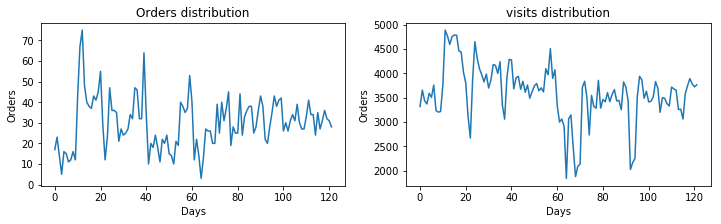

In [97]:
plt.subplot(1, 2, 1)
data["orders"].plot(figsize=(12,3))
plt.title("Orders distribution")
plt.xlabel('Days')
plt.ylabel('Orders')

plt.subplot(1, 2, 2)
data["visits"].plot(figsize=(12,3))
plt.title("visits distribution")
plt.xlabel('Days')
plt.ylabel('Orders')

We can clearly see that the is a seasonality, at least until a certain point of the distribution (from 0 to ~60). Let's see how the two graphs look like when put on top of each other.

In order to have a clear view, we first need to normalize the two values

C:\Users\ASUS\Anaconda3\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning:

Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.

C:\Users\ASUS\Anaconda3\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning:

Data with input dtype int64 was converted to float64 by the normalize function.

C:\Users\ASUS\Anaconda3\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning:

Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.



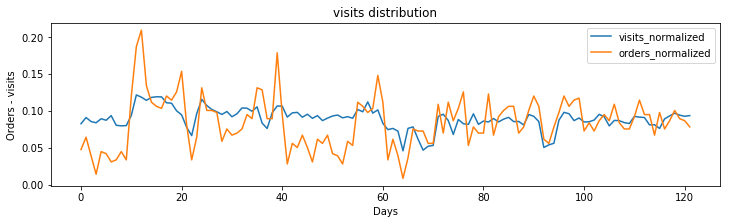

In [98]:
data["visits_normalized"] = preprocessing.normalize(data["visits"])[0]
data["orders_normalized"] = preprocessing.normalize(data["orders"])[0]
data[["visits_normalized","orders_normalized"]].plot(figsize=(12,3))
plt.title("visits distribution")
plt.xlabel('Days')
plt.ylabel('Orders - visits')

At first sight, we can notice at the begining of the distribution a **clear gap** between the blue line (visits) and the orange one (orders). This gap tends to shorten when we move forward in time.

This could be interpreted by the fact that **we are converting more of our visits into orders** which means that the "FREE shipping" strategy has worked (bravo to VC marketing team)

In order to calculate the efficiency of a marketing campaign, we need to track the evolution of an indicator and in our case, this wil be the conversion rate.

The conversion rate is the number of visitors that took an action when visiting our website (in our case this action is buying) divided by the total number of visitor.

Let's calculate and plot that indicator

In [99]:
data["conversion_rate"] = data["orders"] / data["visits"] * 100

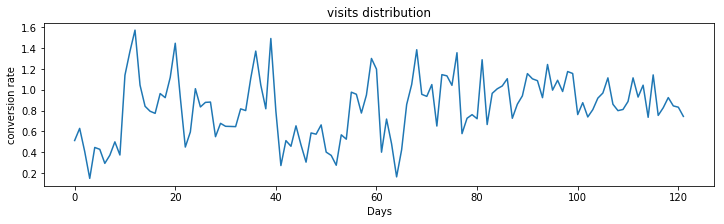

In [100]:
data["conversion_rate"].plot(figsize=(12,3))
plt.title("visits distribution")
plt.xlabel('Days')
plt.ylabel('conversion rate')

The conversion rate fluctuate between 0.1% and 1.6% but we can cleary see that after ~65 days, it stabelizes itself around 1% without ever going under 0.5% (which is not the case before)

Let's see what it looks like when ploted with the visits and the orders 

C:\Users\ASUS\Anaconda3\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning:

Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.



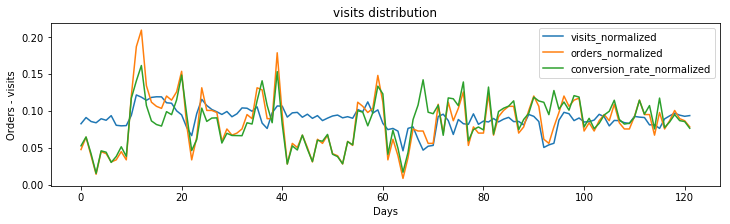

In [101]:
data["conversion_rate_normalized"] = preprocessing.normalize(data["conversion_rate"])[0]
data[["visits_normalized","orders_normalized", "conversion_rate_normalized"]].plot(figsize=(12,3))
plt.title("visits distribution")
plt.xlabel('Days')
plt.ylabel('Orders - visits')

Through this very artistic graph, we can notice that the conversion rate follows the orders trend except around ~69th day where there is a gap beteween the conversion rate and the orders/visits trend. 

This is due to the fact that we arrived to a conversion rate of 1.4% with only 1876 visits and 26 orders. When we compare this conversion rate with earlier points, day 21 for example when we did the same conversion rate, we had to convert 55 people over 3798 visits in order to make the same conversion rate.

Now let's address the seasonality on our data. In order to do so we need a fake date where each "Day" is a real life day.

In [102]:
data["date"] = pd.date_range(start='01-01-2021', periods=len(data), freq='D')

In [103]:
data["conversion_rate"] = data["orders"] / data["visits"]
data = data.set_index("Day")

A serie can be decomposed in four parts (level, noise, trend and seasonality). In python we have function capable on decomposing a time serie in order to define the four parts

In [110]:
def combine_seasonal_cols(df, seasonal_model_results):
    df['observed'] = seasonal_model_results.observed
    df['residual'] = seasonal_model_results.resid
    df['seasonal'] = seasonal_model_results.seasonal
    df['trend'] = seasonal_model_results.trend

In [111]:
df = data[["date","conversion_rate"]].copy()
df = df.set_index("date")
sd = seasonal_decompose(df, period=7,  model='multiplicative')
combine_seasonal_cols(df, sd)

df = df.reset_index()

In [112]:
df.head()

,date,conversion_rate,observed,residual,seasonal,trend
0,2021-01-01,0.005127,0.005127,NaN,0.981526,NaN
1,2021-01-02,0.006294,0.006294,NaN,0.929500,NaN
2,2021-01-03,0.004073,0.004073,NaN,0.873125,NaN
3,2021-01-04,0.001485,0.001485,0.365996,0.991167,0.004092
4,2021-01-05,0.004459,0.004459,1.048287,1.093390,0.003891


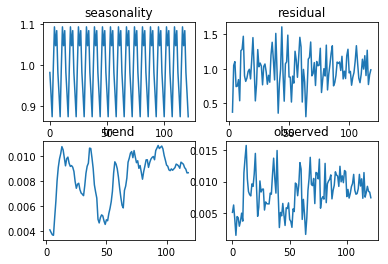

In [113]:
figure, axis = plt.subplots(2, 2)
plt.figure(figsize=(10, 10))

# seasonality 
axis[0][0].plot( df["seasonal"])
axis[0][0].set_title("seasonality")

# trend 
axis[1][0].plot(df["trend"])
axis[1][0].set_title("trend")

# trend 
axis[0][1].plot(df["residual"])
axis[0][1].set_title("residual")

# trend 
axis[1][1].plot(df["observed"])
axis[1][1].set_title("observed")


plt.show()

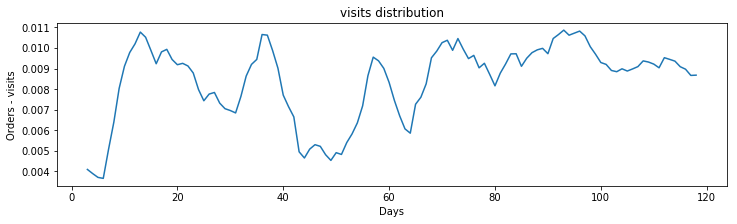

In [114]:
df["trend"].plot(figsize=(12,3))
plt.title("visits distribution")
plt.xlabel('Days')
plt.ylabel('Orders - visits')

We can clearly notice that the trend is the same for the first 60 days of our data and then it peaks and stablise itself util the end.

Based on the hypothesis that when the promotion is launched, it wenton until the end of the data, we can assume that this change of trend can be the result of the Free shipping start.

To find out which date it is, we need to find the last minimum of the serie...

In [116]:
data = data.reset_index()

In [117]:
min_conversion_rate = data[data.Day > 60]["conversion_rate"].min()
data[data.conversion_rate == min_conversion_rate]

,Day,visits,orders,visits_normalized,orders_normalized,conversion_rate,conversion_rate_normalized,date
64,65,1840,3,0.045786,0.008379,0.00163,0.016719,2021-03-06


Let's assume that time is needed between the launch of the Free shipping and the result (we especially need to market the promo to our customers), we can easily say that the FREE Shipping promo was launched on the 65th (+- 2 days) before peaking  on the 69th at 1.4% of conversion.

In [134]:
data_with_free_ship = data[data.Day > 67]

In [135]:
data_with_free_ship.describe()

,Day,visits,orders,visits_normalized,orders_normalized,conversion_rate,conversion_rate_normalized
count,55.00000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000
mean,95.00000,3355.472727,31.727273,0.083496,0.088609,0.009544,0.097871
std,16.02082,521.430257,6.864980,0.012975,0.019173,0.001840,0.018869
min,68.00000,1876.000000,19.000000,0.046681,0.053064,0.005789,0.059365
25%,81.50000,3282.500000,26.000000,0.081680,0.072614,0.008106,0.083119
50%,95.00000,3486.000000,31.000000,0.086744,0.086578,0.009422,0.096615
75%,108.50000,3703.500000,37.500000,0.092156,0.104732,0.010991,0.112705
max,122.00000,3937.000000,45.000000,0.097966,0.125678,0.013859,0.142121


In [136]:
data[data.Day < 67].describe()

,Day,visits,orders,visits_normalized,orders_normalized,conversion_rate,conversion_rate_normalized
count,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000
mean,33.500000,3795.575758,28.621212,0.094447,0.079935,0.007287,0.074727
std,19.196354,559.982721,15.442962,0.013934,0.043130,0.003370,0.034557
min,1.000000,1840.000000,3.000000,0.045786,0.008379,0.001485,0.015224
25%,17.250000,3491.500000,16.000000,0.086881,0.044686,0.004604,0.047214
50%,33.500000,3793.500000,24.500000,0.094395,0.068425,0.006585,0.067523
75%,49.750000,4092.750000,38.000000,0.101842,0.106128,0.009447,0.096880
max,66.000000,4885.000000,75.000000,0.121556,0.209464,0.015743,0.161438


# BONUS


A way simpler solution is to calculate the mean of the conversion rate with a cursor since we know that when the promo is launched, it is on for the rest of the data.

In [150]:
def get_cursor_mean_conversion_rate(df):
    mean_conversion_rate = pd.DataFrame(columns=["day","mean_conversion_rate"])
    for i in range(0, df.shape[0]):
        mean = df[data.Day > i]["conversion_rate"].mean()
        mean_conversion_rate = mean_conversion_rate.append({"day":i, "mean_conversion_rate":mean}, ignore_index=True)
        
    return mean_conversion_rate

In [151]:
mean_conversion_rate = get_cursor_mean_conversion_rate(data)

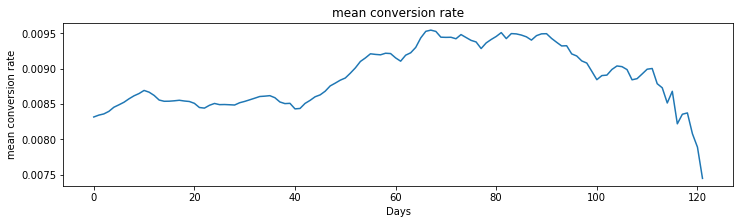

In [153]:
mean_conversion_rate["mean_conversion_rate"].plot(figsize=(12,3))
plt.title("mean conversion rate")
plt.xlabel('Days')
plt.ylabel('mean conversion rate')

In [154]:
max_mean_conversion_rate = mean_conversion_rate.mean_conversion_rate.max()
mean_conversion_rate[mean_conversion_rate.mean_conversion_rate == max_mean_conversion_rate]

,day,mean_conversion_rate
67,67.0,0.009544


This result validates our findings from earlier where we found that the promo was launched on 65th day more or less 2 days which means 67